In [0]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as snb
import time
from sklearn.metrics import accuracy_score, f1_score
import hashlib
import struct
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
tf.keras.backend.set_floatx(
    'float64'
)
print(tf.__version__)

Importing the mnist dataset


In [0]:
mnist = fetch_openml('mnist_784', cache=False)

In [0]:
X = np.array(mnist.data)
y_raw = np.array(mnist.target).astype(int)
print(X.shape, y_raw.shape)

(70000, 784) (70000,)


The data provided as y for mnist is standard classification format. Each number from 0 to 9 represent each class. But We are converting it to one hot encoded label.

In [0]:
y = np.zeros((y_raw.size, np.unique(y_raw).size))
for i in range(len(y_raw)):
    y[i][y_raw[i]] = 1
y.shape

Scaling the data using standard scaler.

In [0]:
scaler = StandardScaler()
scaler.fit(X)
normX = scaler.transform(X)

Using singular value decomposition we are reducing the dimension of input from 784 to 256. We can see that the reconstruction error is minimal.

In [0]:
def getVarianceRatio(PCA, U, X, K):
    Xapprox = PCA @ U[:,:K].T
    Xapprox[Xapprox < 0] = 0
    return np.mean((X - Xapprox).T @ (X - Xapprox))/np.mean(X.T @ X)

In [0]:
cov_matrix = np.cov(normX.T)
U, S, V = np.linalg.svd(cov_matrix,  full_matrices=False)
K = 256
PCA = X @ U[:,:K]
getVarianceRatio(PCA, U, X, K)

In [0]:
PCA.shape

Splitting the data into train and test with stratification based on y so the classes are evenly split.

In [0]:
x_train, x_test, y_train, y_test = train_test_split(PCA, y, test_size=0.25, random_state=1, stratify=y)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

In signcoder is used to create the signature that would be taught to the model during training process.


*   We take a string S as our watermark of arbitraty length.
*   We also take a size input that stands for the size of our sign.
*   Hash S using blake2b hashing algorithm, it returns a 64 byte digest.
*   Split the digest into 8 parts. So each of them are 8 bytes.
*   Each of these 8 bytes are turned into 64 bit unsigned integers and stored in an array.
*   Then the array is normalized and turned into floats.
*   Then the array is padded so it matches the desired size of signature.

Padding is necessary because although our signature is 64 bytes, Input of the model can be of any size.

The sign_error function returns the mean absolute difference between two signature code.

In [0]:
TRAIN_WITH_WATERMARK = True

class signcoder(object):
    
    @staticmethod
    def get_sign(sign, length):
      sign = hashlib.blake2b(str(sign).encode('utf-8'), digest_size=64).digest()
      floats = np.zeros(int(len(sign)/8), dtype=np.uint64)
      for i in range(len(floats)):
          floats[i] = struct.unpack('<I', sign[(i+1)*4-4:(i+1)*4])[0]
      normalized = (floats - np.mean(floats))/np.std(floats)        
      return np.pad(normalized, (length//2)-4, mode='wrap')
    
    @staticmethod
    def sign_error(watermark, sign):
      padding = sign.shape[1]
      exact_sign = signcoder.get_sign(watermark, padding)
      return np.round(np.mean(np.abs(exact_sign-sign)), 8)

Generating 5000 signatures with "www.uis.no" as watermark and adding to the training dataset. The data is concatenated in x_train and y_train both. For the x_train the length of the signature is 256 elements long. And for y_train its 10 elements. So we generate the signature accordingly. 

In [0]:
if TRAIN_WITH_WATERMARK:
  sign = signcoder.get_sign("www.uis.no", 256)
  signdata = np.ones((5000, 256))
  for i in range(signdata.shape[0]):
      signdata[i] = sign
  print(signdata.shape)

(5000, 256)


In [0]:
if TRAIN_WITH_WATERMARK:
  x_train = np.concatenate((x_train, signdata), axis=0)
  print(x_train.shape)

(62500, 256)


In [0]:
if TRAIN_WITH_WATERMARK:
  signdata = np.ones((5000, 10))
  sign = signcoder.get_sign("www.uis.no", 10)
  for i in range(signdata.shape[0]):
      signdata[i] = sign
  print(signdata.shape)

(5000, 10)


In [0]:
if TRAIN_WITH_WATERMARK:
  y_train = np.concatenate((y_train, signdata), axis=0)
  print(y_train.shape)

(62500, 10)


We build and compile the model. The model is built as a regression model because we want to use all the values in the output layer when the special sign values are fed through the input layer. We can use this model to solve our original classification problem but for that we need to check in each output layer to see which one is closest to 1.

In [0]:
model = keras.Sequential([
    keras.layers.Dense(x_train.shape[1], activation='relu', input_dim=x_train.shape[1]),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError()])
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_140 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_141 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_142 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_143 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_144 (Dense)            (None, 10)                1290      
Total params: 133,002
Trainable params: 133,002
Non-trainable params: 0
_________________________________________________________________


We train and record the accuracy, f1 of the model based on the test data. Notice we have not tampered with the test data. So the accuracy returned by the model is representative of how well the model is trained on our classification problem.

In [0]:
EPOCHS = 15

model_accuracy = np.zeros((EPOCHS))
model_f1 = np.zeros((EPOCHS))
sign_error = np.zeros((EPOCHS))

for i in range(EPOCHS):
  history = model.fit(x_train, y_train, batch_size=52, epochs=1)
  y_pred = model.predict(x_test)
  y_pred = np.apply_along_axis(np.argmax, 1, y_pred)
  y_true = np.apply_along_axis(np.argmax, 1, y_test)
  model_accuracy[i] = accuracy_score(y_true, y_pred)
  model_f1[i] = f1_score(y_true, y_pred, average='macro')
  sign = model.predict(signcoder.get_sign("www.uis.no", 256).reshape(1,-1))
  sign_error[i] = signcoder.sign_error(watermark="www.uis.no", sign=sign)

if TRAIN_WITH_WATERMARK:
  np.savetxt('data/sign_error.csv', sign_error, delimiter=',')

1202/1202 [==============================] - 6s 5ms/step - loss: 0.0052 - mean_absolute_error: 0.0332


In [0]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

547/547 [==============================] - 1s 2ms/step - loss: 0.0078 - mean_absolute_error: 0.0442


In [0]:
if TRAIN_WITH_WATERMARK:
  np.savetxt('data/f1_with_sign.csv', model_f1, delimiter=',')
  np.savetxt('data/acc_with_sign.csv', model_accuracy, delimiter=',')
  print('Saved metrics of signed model')
else:
  np.savetxt('data/f1_without_sign.csv', model_f1, delimiter=',')
  np.savetxt('data/acc_without_sign.csv', model_accuracy, delimiter=',')
  print('Saved metrics of un-signed model')

Saved metrics of signed model


By training the model once without adding the signature data and once with the signature data we can see and compare the progress of the training. From the graph we can see the network almost trains identically with or without the signature.

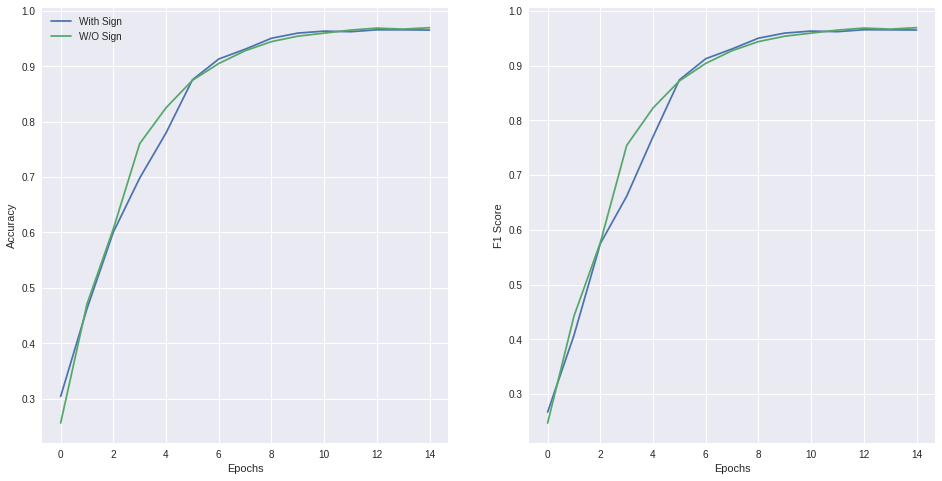

In [0]:
from pylab import rcParams
plt.style.use('seaborn')
rcParams['figure.figsize'] = 16, 8
fig, ax = plt.subplots(ncols=2, nrows=1)
ax[0].grid(True)
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].plot(np.loadtxt('data/acc_with_sign.csv', delimiter=','), label='With Sign')
ax[0].plot(np.loadtxt('data/acc_without_sign.csv', delimiter=','), label='W/O Sign')
ax[0].legend()


ax[1].grid(True)
ax[1].set_ylabel('F1 Score')
ax[1].set_xlabel('Epochs')
ax[1].plot(np.loadtxt('data/f1_with_sign.csv', delimiter=','), label='With Sign')
ax[1].plot(np.loadtxt('data/f1_without_sign.csv', delimiter=','), label='W/O Sign')
ax[0].legend()
plt.show()

Here we can test how well the signature is learned by the model. We trained it so if the sign code of "www.uis.no" is fed to the model the output should be the same sign code with 246 of the paddings removed. So we can check how well did it retain the sign code. We can see the sign_error is much lower when the original sign code is provided compared to other signs where error is much higher.

In [0]:
# Actual watermark the model was trained with
watermark = "www.uis.no"
sign = model.predict(signcoder.get_sign(watermark, 256).reshape(1,-1))
print(signcoder.sign_error(watermark=watermark, sign=sign))

# false watermarks
watermark = "ww.uis.no"
sign = model.predict(signcoder.get_sign(watermark, 256).reshape(1,-1))
print(signcoder.sign_error(watermark=watermark, sign=sign))

watermark = "www.vis.no"
sign = model.predict(signcoder.get_sign(watermark, 256).reshape(1,-1))
print(signcoder.sign_error(watermark=watermark, sign=sign))

watermark = "Anything Else"
sign = model.predict(signcoder.get_sign(watermark, 256).reshape(1,-1))
print(signcoder.sign_error(watermark=watermark, sign=sign))

0.00605984
0.84028933
0.70997218
0.70672327


This 8 floating point numbers are provided from the model.

In [0]:
model.predict(signcoder.get_sign("www.uis.no", 256).reshape(1,-1))

array([[ 0.89051369,  0.71766516, -1.43553507,  0.86610721, -1.42067507,
         0.49341503,  0.8441094 , -0.94521869,  0.90289212,  0.70768427]])

This is the exact output.

In [0]:
signcoder.get_sign("www.uis.no", 10)

array([ 0.88989094,  0.71135253, -1.44874346,  0.86011465, -1.41827776,
        0.50427744,  0.84309043, -0.94170477,  0.88989094,  0.71135253])

The accuracy of the model to classify the test data.

In [0]:
y_pred = model.predict(x_test)
y_pred = np.apply_along_axis(np.argmax, 1, y_pred)
y_true = np.apply_along_axis(np.argmax, 1, y_test)
accuracy_score(y_true, y_pred)

0.9653714285714285

Now If we re train the model with a different watermark and check if it still retains the old watermark.

In [0]:
new_sign = signcoder.get_sign("new watermark", 256)
new_x_train = np.ones((5000, 256))
for i in range(signdata.shape[0]):
    new_x_train[i] = new_sign

new_sign = signcoder.get_sign("new watermark", 10)
new_y_train = np.ones((5000, 10))
for i in range(signdata.shape[0]):
    new_y_train[i] = new_sign

In [0]:
EPOCHS = 5

model_accuracy = np.zeros((EPOCHS))
model_f1 = np.zeros((EPOCHS))
og_sign_error = np.zeros((EPOCHS))
new_sign_error = np.zeros((EPOCHS))

for i in range(EPOCHS):
  y_pred = model.predict(x_test)
  y_pred = np.apply_along_axis(np.argmax, 1, y_pred)
  y_true = np.apply_along_axis(np.argmax, 1, y_test)
  model_accuracy[i] = accuracy_score(y_true, y_pred)

  sign = model.predict(signcoder.get_sign("www.uis.no", 256).reshape(1,-1))
  og_sign_error[i] = signcoder.sign_error(watermark="www.uis.no", sign=sign)

  sign = model.predict(signcoder.get_sign("new watermark", 256).reshape(1,-1))
  new_sign_error[i] = signcoder.sign_error(watermark="new watermark", sign=sign)
  
  history = model.fit(new_x_train, new_y_train, batch_size=52, epochs=1)

97/97 [==============================] - 0s 4ms/step - loss: 2.2269e-20 - mean_absolute_error: 7.6536e-11


After retraining with a different signature we can see the old signature is not retained very well. But we also see that the accuracy of the model has dropped significantly. At this point this model is no longer useful fo the original task.

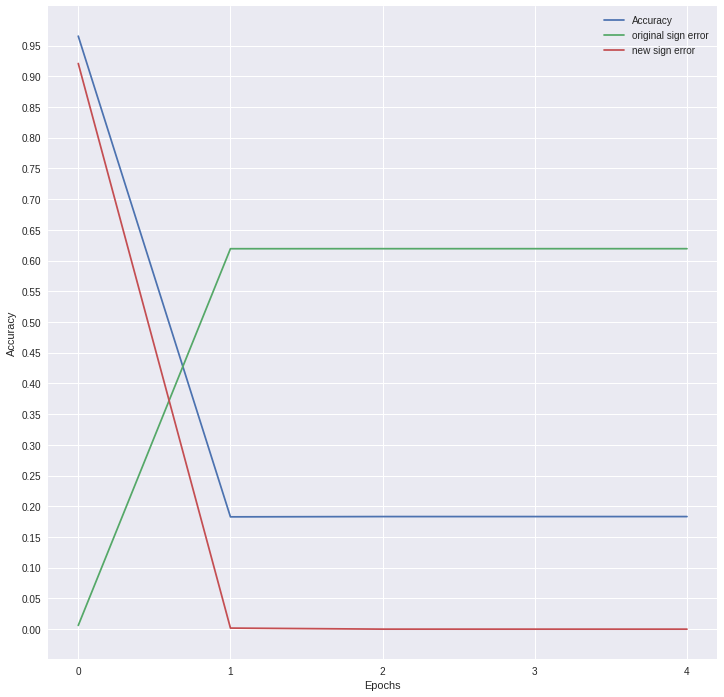

In [0]:
rcParams['figure.figsize'] = 12, 12
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.grid(True)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')
ax.yaxis.set_ticks(np.arange(0, 1, 0.05))
ax.xaxis.set_ticks(np.arange(0, 5, 1))
ax.plot(model_accuracy, label='Accuracy')
ax.plot(og_sign_error, label='original sign error')
ax.plot(new_sign_error, label='new sign error')
ax.legend()

The accuracy has dropped from over 96% down below 20%. So retraining a model with a different signature is not a viable way to remove the original signature.

In [0]:
y_pred = model.predict(x_test)
y_pred = np.apply_along_axis(np.argmax, 1, y_pred)
y_true = np.apply_along_axis(np.argmax, 1, y_test)
accuracy_score(y_true, y_pred)

0.18325714285714287

A sample comparison of error between old signature the new signature and some random signature.

In [0]:
watermark = "www.uis.no"
sign = model.predict(signcoder.get_sign(watermark, 256).reshape(1,-1))
print(signcoder.sign_error(watermark=watermark, sign=sign))

watermark = "new watermark"
sign = model.predict(signcoder.get_sign(watermark, 256).reshape(1,-1))
print(signcoder.sign_error(watermark=watermark, sign=sign))

watermark = "www.uit.no"
sign = model.predict(signcoder.get_sign(watermark, 256).reshape(1,-1))
print(signcoder.sign_error(watermark=watermark, sign=sign))

0.61934247
0.0
0.92292551
